# Catastrophic forgetting

In this notebook, we investigate the performance of a neural network trained sequentually on every MNIST digit. We setup a simulation with 10 partners, every partner having only data corresponding to one digit. The neural network is then trained sequentially on every partner. This is an extreme scenario intended to highlight the possible catastrophic forgetting of the model, which means that the model might unlearn the previous learnt digits each time it learns on a new partner.

## Results

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import pickle


# Read CSV results
df = pd.read_csv("results.csv")

In [6]:
# Config file
with open("config.yml") as f:
     print(f.read())

experiment_name: patience_sept
n_repeats: 40
scenario_params_list:
 - dataset_name:
    'mnist':
    - 'random_initialization'
   partners_count: 
     - 10
   amounts_per_partner: 
     - [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
   samples_split_option: 
     - ['advanced', [[1, 'specific'], [1, 'specific'], [1, 'specific'], [1, 'specific'], [1, 'specific'], [1, 'specific'], [1, 'specific'], [1, 'specific'], [1, 'specific'], [1, 'specific']]]
   multi_partner_learning_approach:
     - 'seq-pure'
   aggregation_weighting: 
     - 'uniform' 
   gradient_updates_per_pass_count: 
     - 8
   epoch_count: 
     - 100
   minibatch_count: 
     - 1
     - 3
     - 10



The only parameter that varies is the *minibatch_count*. We supposed that if we increase the mini-batch the system will learn more (and therefore will unlearn more).

In [7]:
scenario_ids = df.scenario_id.unique()
random_states = df.random_state.unique()
samples_split_descriptions = df.samples_split_description.unique()
dataset_fraction_per_partner_list = df.dataset_fraction_per_partner.unique()
gradient_updates_per_pass_count_list = df.gradient_updates_per_pass_count.unique()

print('Random state', random_states)
print('Scenario id', scenario_ids)

Random state [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Scenario id [0 1 2]


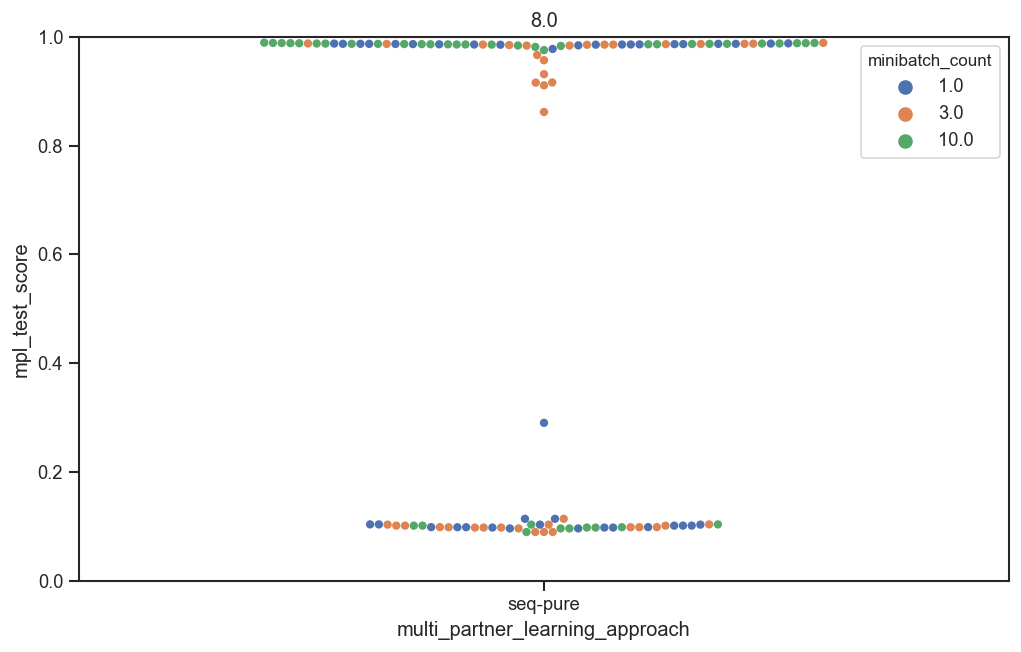

In [8]:
# Plot loop
for dataset_fraction_per_partner in dataset_fraction_per_partner_list:
    for gradient_updates_per_pass_count in gradient_updates_per_pass_count_list:
        
        current_df = df[(df.dataset_fraction_per_partner == dataset_fraction_per_partner) &
                        (df.gradient_updates_per_pass_count == gradient_updates_per_pass_count)]

        sns.set(style="ticks")
        #current_df.info()


        plt.figure(figsize=(10, 6), dpi=120)
        plt.title(gradient_updates_per_pass_count)
        ax = sns.swarmplot(x="multi_partner_learning_approach", y="mpl_test_score", hue="minibatch_count",
                           data=current_df)
        plt.ylim([0, 1])


        plt.show()
    

Looking at this graph above, it's not clean when the training works and when it does not. Let's look at the losses to investigate further.

## Investigate Losses

To investigate further we restrict ourself to scenario with *minibatch_count == 1*, we could have done the same investigation with another value of *minibatch_count*.

In [9]:
df_seq = df[(df.multi_partner_learning_approach == "seq-pure") & (df.minibatch_count == 1)]
df_seq.head()

,aggregation_weighting,dataset_fraction_per_partner,dataset_name,epoch_count,final_relative_nb_samples,gradient_updates_per_pass_count,is_early_stopping,learning_computation_time_sec,minibatch_count,mpl_nb_epochs_done,...,multi_partner_learning_approach,nb_samples_used,partners_count,samples_split_description,scenario_name,short_scenario_name,test_data_samples_count,train_data_samples_count,random_state,scenario_id
0,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",mnist,100.0,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",8.0,1.0,155.443839,1.0,31.0,...,seq-pure,43170.0,10.0,"[[1, 'specific'], [1, 'specific'], [1, 'specif...",scenario_1_repeat_1_2020-09-07_17h37_d73,"10 [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0....",10000.0,48000.0,0,0
3,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",mnist,100.0,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",8.0,1.0,351.144490,1.0,73.0,...,seq-pure,43170.0,10.0,"[[1, 'specific'], [1, 'specific'], [1, 'specif...",scenario_1_repeat_2_2020-09-07_20h08_f0e,"10 [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0....",10000.0,48000.0,1,0
6,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",mnist,100.0,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",8.0,1.0,336.258587,1.0,70.0,...,seq-pure,43170.0,10.0,"[[1, 'specific'], [1, 'specific'], [1, 'specif...",scenario_1_repeat_3_2020-09-07_22h13_c77,"10 [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0....",10000.0,48000.0,2,0
9,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",mnist,100.0,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",8.0,1.0,149.945562,1.0,31.0,...,seq-pure,43170.0,10.0,"[[1, 'specific'], [1, 'specific'], [1, 'specif...",scenario_1_repeat_4_2020-09-08_00h23_632,"10 [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0....",10000.0,48000.0,3,0
12,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",mnist,100.0,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",8.0,1.0,148.608443,1.0,31.0,...,seq-pure,43170.0,10.0,"[[1, 'specific'], [1, 'specific'], [1, 'specif...",scenario_1_repeat_5_2020-09-08_02h27_074,"10 [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0....",10000.0,48000.0,4,0


In [10]:
plt.rcParams.update({'figure.max_open_warning': 0})

seq_scenario_names_list = df_seq.scenario_name

for scenario_name in df_seq.scenario_name:
    scenario_path = experiment_path / scenario_name
    history_data_path = scenario_path / "history_data.p"
    
    with open(history_data_path, 'rb') as f:
        loss_data = pickle.load(f)

    loss_collective_models = loss_data["loss_collective_models"]
    loss_collective_models = loss_collective_models[1:] 

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120)
    fig.suptitle(scenario_name)

    ax1.plot(np.arange(len(loss_collective_models)), loss_collective_models)
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Global loss")
    ax1.set_ylim([0, 3])
    ax1.set_xlim([0, df_seq.epoch_count.max()])

    score_matrix_per_partner = loss_data["score_matrix_per_partner"]
    score_matrix_per_partner.shape
    score_matrix_per_partner[score_matrix_per_partner == 0] = 'nan'
    global_validation_score = score_matrix_per_partner[:, 0, :]
    
    ax2.plot(np.arange(len(global_validation_score)), global_validation_score)
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Global validation scores")
    ax2.set_ylim([0, 1])
    ax2.set_xlim([0, df_seq.epoch_count.max()])


NameError: name 'experiment_path' is not defined

Three important things:
* At every epoch the order of the partners for the sequential round is random.
* The weights initialization is different for every experiment.
* Concerning early stopping, the patience parameter was 30.

Looking at the graph above, it looks like sometimes the loss is stuck in a local minima. The neural networks learns too much on each parter data, and forgets the data it has seen before.

Things that might be helpful to investigate further:
* if we decrase the learning rate, we might see less catastrophic forgetting since the neural network will learn less at each step.
* Looking at the validation score for the partner after every minibatch (and not every epoch) to have an idea of how quickly the model forgets.